In [2]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [20]:
spikes=np.load('/media/maria/DATA1/Documents/NeuroMatchAcademy2020_dat/spk_arr2.npy')*1000
cell_identity=np.load('/media/maria/DATA1/Documents/NeuroMatchAcademy2020_dat/cell_identity2.npy')

In [26]:
def get_good_cells(fdirpath): #
    # location in brain of each neuron
    brain_loc = os.path.join(fdirpath, "channels.brainLocation.tsv")

    good_cells = (np.load(os.path.join(fdirpath, "clusters._phy_annotation.npy")) >= 2 ).flatten()
    clust_channel = np.load(os.path.join(fdirpath, "clusters.peakChannel.npy")).astype(int) - 1
    br = []
    with open(brain_loc, 'r') as tsv:
        tsvin = csv.reader(tsv, delimiter="\t")
        k=0
        for row in tsvin:
            if k>0:
                br.append(row[-1])
            k+=1
    br = np.array(br)
    good_cells = np.logical_and(good_cells, clust_channel.flatten()<len(br))
    brain_region = br[clust_channel[:,0]]


    return good_cells, brain_region, br

def bin_spikes(spike_times,spike_clusters, bin_size = 10):

    # Using clusters._phy_annotation.npy obtain valid clusters (i.e. >= 2)
    # valid_clusters_idx = np.array(np.where(clusters_annotation>=2))[0]

    spike_time_cells = np.empty(1000, dtype=object) # Initalise empty object
    for i in (np.arange(len(np.unique(spike_clusters)))):
      # Create a spike time arrays, where each array in the array is a spike time of a cell
      spike_time_cells[i] = spike_times[(np.where(spike_clusters == i)[0])]

    # Bin spike times into 10ms intervals
    spike_time_binned = np.empty(len(np.unique(spike_clusters)), dtype=object) # Initalise empty object
    sum_spikes = np.empty(len(np.unique(spike_clusters)), dtype=object) # Initalise empty object

    for cell_num in np.arange(len(spike_time_cells)):
        spike_time_hist = np.histogram(spike_time_cells[cell_num],bins = np.arange(0,np.floor(spike_time_cells[cell_num][-1]),bin_size))
        spike_time_binned[cell_num] = spike_time_hist[0][:9000]
        sum_spikes[cell_num] = np.sum(spike_time_binned[cell_num])

    cell_spikes_max = np.argmax(sum_spikes) # cell with the maximum number of spikes for plotting purposes

    # Spike_time_binned returns binned spikes sorted into cells
    # Spike_time_cells returns UNbinned spikes sorted into cells
    # cell_spikes_max returns a single cell index that has the max number of spikes (i.e most active cell)
    return spike_time_binned

In [13]:
print(min(cell_identity))

0


In [27]:
spikes_binned=bin_spikes(spikes,cell_identity, bin_size = 10)

In [23]:
print(spikes_binned[2])

[0 0 0 ... 0 0 0]


In [24]:
len(spikes_binned)

1000

In [25]:
lst=[]
for j in range(1000):
    lst.append(spikes_binned[j].shape[0])
print(min(lst))

9471


In [28]:
spikes_binned=np.array(spikes_binned)

In [30]:
print(spikes_binned[0].shape)

(9000,)


In [31]:
lst=[]
for j in range(1000):
    lst.append(list(spikes_binned[j]))
lst=np.array(lst)

In [32]:
lst.shape

(1000, 9000)

In [33]:
spikes_binned=lst

In [34]:
rates=np.sum(spikes_binned,axis=1)/90

In [35]:
print(rates)

[4.44444444e-02 6.11111111e-01 5.77777778e-01 1.10444444e+01
 4.00000000e-01 1.16666667e+00 3.31111111e+00 5.77777778e-01
 2.77777778e-01 3.22222222e+00 1.52222222e+00 5.35555556e+00
 2.33333333e-01 4.33333333e-01 5.00000000e-01 4.88888889e-01
 6.88888889e-01 7.77777778e-02 3.66666667e+00 2.86666667e+00
 2.57777778e+00 8.88888889e-02 2.12222222e+00 3.33333333e-02
 7.66666667e-01 8.88888889e-02 1.43333333e+00 2.22222222e+00
 4.44444444e-01 4.44444444e-02 8.55555556e-01 6.33333333e-01
 5.05555556e+00 1.61111111e+00 4.75555556e+00 2.55555556e-01
 2.77777778e-01 8.18888889e+00 6.08888889e+00 6.33333333e-01
 1.11111111e-02 4.36666667e+00 4.77777778e-01 3.36666667e+00
 7.77777778e-02 2.64444444e+00 9.46666667e+00 3.14444444e+00
 5.37777778e+00 5.66666667e-01 7.00000000e-01 6.44444444e-01
 5.28888889e+00 8.38888889e+00 1.44444444e-01 9.44444444e-01
 2.65555556e+00 5.88888889e-01 1.22222222e+00 7.77777778e-02
 6.81111111e+00 6.44444444e-01 5.88888889e-01 1.67777778e+00
 8.44444444e-01 8.111111

In [37]:
start=time.time()
simulation_clock=Clock(dt = 0.1*ms)
defaultclock.dt = 0.1*ms
tau = 10*ms
vr = -70*mV
vt = -60*mV
eqs = '''
dv/dt = I_ampa/Cm : volt
I_ampa=-g_ext_ampa*s_ext*(v-E_ampa) : amp
ds_ext/dt=-s_ext/t_ampa : 1
'''
t_ampa=2*ms
Cm= 0.5*nF
E_ampa=0.0*mV
g_ext_ampa=3.1*nS
neuron = NeuronGroup(100, eqs, threshold='v>vt', reset='v=vr')
neuron.v = E_ampa
neuron.s_ext = 0
spikes_gen=PoissonGroup(1000,rates=rates*Hz)
w = 1
S = Synapses(spikes_gen, neuron, on_pre='s_ext += w')
S.connect(p=0.1)
# Record the spikes
Mgp = SpikeMonitor(neuron)
Minput = SpikeMonitor(spikes_gen)
pop=PopulationRateMonitor(spikes_gen)
I_ampa_lst_poisson=[]
@network_operation(simulation_clock,when='start')
def update_nmda(simulation_clock):
    I_ampa=np.sum(neuron.I_ampa[:])
    I_ampa_lst_poisson.append(I_ampa)
duration=10000*ms
run(duration)
end=time.time()
print(end-start)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.03s, trying other methods took 0.03s). [brian2.stateupdaters.base.method_choice]
WARNING    "rates" is an internal variable of group "poissongroup", but also exists in the run namespace with the value array([0.04444444, 0.61111111, 0.57777778, ..., 0.61111111, 0.38888889,
       0.55555556]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


470.39926624298096


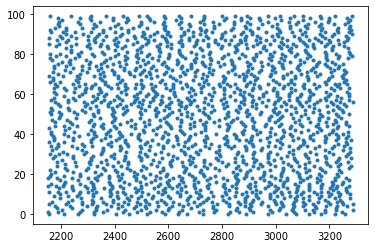

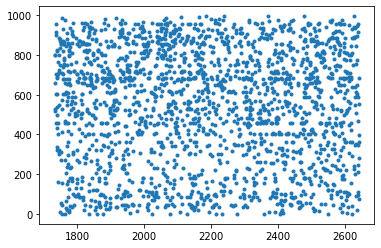

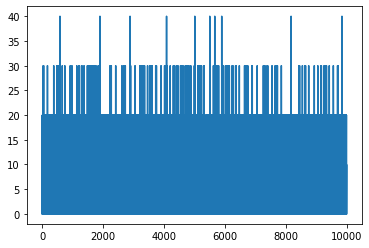

In [38]:
plot(Mgp.t[4000:6000]/ms, Mgp.i[4000:6000], '.')
plt.show()
plot(Minput.t[4000:6000]/ms,Minput.i[4000:6000],'.')
plt.show()
plot(pop.t/ms, pop.rate/Hz)

In [39]:
np.save('Mgpt_poisson_rate_matched.npy',Mgp.t)
np.save('Mgpi_poisson_rate_matched.npy',Mgp.i)
np.save('I_ampa_poisson_rate_matched.npy',I_ampa_lst_poisson)